# Assignment 2

## Group members
- Axel Gustafsson - gusgusaxa@student.gu.se
- Erdem Halil - gushaliler@student.gu.se

#### 1. Reading the review data

In [635]:
def read_documents(doc_file):
    docs = []
    labels = []
    with open(doc_file, encoding='utf-8') as f:
        for line in f:
            words = line.strip().split()
            docs.append(words[3:])
            labels.append(words[1])
    return docs, labels

all_docs, all_labels = read_documents('reviews.txt')

split_point = int(0.80*len(all_docs))
train_docs = all_docs[:split_point]
train_labels = all_labels[:split_point]  
val_docs = all_docs[split_point:]
val_labels = all_labels[split_point:]

#### 2. Estimating parameters for the Naive Bayes classifier

In [636]:
from collections import Counter
import numpy as np

def train_nb(documents, labels):
    # Compute the prior log probabilities
    prior = Counter(labels)
    for label in prior:
        prior[label] = np.log(prior[label] / len(labels))

    # Set to store all unique words in the training set
    unique_words = set()
    # Dict to count the number of words in each class
    words = {label: 0 for label in prior}

    # Count the number of times each word appears in each class
    likelihood = {}
    for doc, label in zip(documents, labels):
        unique_words.update(doc)    # Update the set with each word in the document
        for word in doc:
            if word not in likelihood:
                likelihood[word] = {label: 0 for label in prior}
            likelihood[word][label] += 1    # Increment the count for the word in the document
            words[label] += 1   # Increment the count of words in the class

    # Get the vocabulary
    vocab = len(unique_words)

    # Compute the log likelihood
    for word in likelihood:
        for label in likelihood[word]:
            # Add 1 to the numerator and vocab to the denominator for smoothing
            likelihood[word][label] = np.log((likelihood[word][label] + 1) / (words[label] + vocab))
    
    return prior, likelihood

prior, likelihood = train_nb(train_docs, train_labels)
prior

Counter({'neg': -0.7103971982200179, 'pos': -0.6761896870922498})

#### 3. Classifying new documents

In [637]:
def score_doc_label(document, label, prior, likelihood):
    # Initialize the score with the prior probability of the class
    score = prior[label]
    for word in document:
        if word in likelihood:
            # Add the log likelihood of the word to the score
            score += likelihood[word][label]
    return score

# Sanity check 1
print("Sanity check 1")
great_pos_score = np.exp(score_doc_label(['great'], 'pos', prior, likelihood))
print(f"Great with positive label: {great_pos_score}")
great_neg_score = np.exp(score_doc_label(['great'], 'neg', prior, likelihood))
print(f"Great with negative label: {great_neg_score}")

bad_pos_score = np.exp(score_doc_label(['bad'], 'pos', prior, likelihood))
print(f"Bad with positive label: {bad_pos_score}")
bad_neg_score = np.exp(score_doc_label(['bad'], 'neg', prior, likelihood))
print(f"Bad with negative label: {bad_neg_score}")

# Sanity check 2
print("\nSanity check 2")
crash_pos_score = np.exp(score_doc_label(['a', 'top-quality', 'performance'], 'pos', prior, likelihood))
print(f"['a', 'top-quality', 'performance'] with positive label: {crash_pos_score}")
crash_neg_score = np.exp(score_doc_label(['a', 'top-quality', 'performance'], 'neg', prior, likelihood))
print(f"['a', 'top-quality', 'performance'] with negative label: {crash_neg_score}")

Sanity check 1
Great with positive label: 0.0013212141496043825
Great with negative label: 0.0005283997934747295
Bad with positive label: 0.00017230368700664423
Bad with negative label: 0.0004547440646873432

Sanity check 2
['a', 'top-quality', 'performance'] with positive label: 2.739162445438219e-06
['a', 'top-quality', 'performance'] with negative label: 1.3890482802798863e-06


In [638]:
def classify_nb(document, prior, likelihood):
    labels = prior.keys()   # Get all possible labels
    best_score = float('-inf') # Initialize the best score to be -infinity
    best_label = None

    # Go through each label, compute the score for the document and pick the best label based on score
    for label in labels:
        score = score_doc_label(document, label, prior, likelihood)
        if score > best_score:
            best_score = score
            best_label = label

    return best_label

# Sanity check
test_label = classify_nb(["bad", "movie", "worst", "don't", "disappointing", "watch", "awful"], prior, likelihood)
print(f'["bad", "movie", "worst", "don\'t", "disappointing", "watch", "awful"]: {test_label}')

test_label = classify_nb(["I", "love", "this", "movie", "definitely", "recommend", "fantastic"], prior, likelihood)
print(f'["I", "love", "this", "movie", "definitely", "recommend", "fantastic"]: {test_label}')

["bad", "movie", "worst", "don't", "disappointing", "watch", "awful"]: neg
["I", "love", "this", "movie", "definitely", "recommend", "fantastic"]: pos


#### 4. Evaluating the classifier

In [639]:
def classify_documents(documents, prior, likelihood):
    labels = []
    # Classify each document and return the labels based on the classification
    for doc in documents:
        labels.append(classify_nb(doc, prior, likelihood))
    return labels

In [640]:
def accuracy(true_labels, guessed_labels):
    correct = 0
    for true, guessed in zip(true_labels, guessed_labels):
        if true == guessed:
            correct += 1
    return correct / len(true_labels)

guessed_labels = classify_documents(val_docs, prior, likelihood)
print(f"Accuracy for validation documents: {accuracy(val_labels, guessed_labels)}")

Accuracy for validation documents: 0.8153587914393622


In [641]:
def f1_score(true_labels, guessed_labels, positive_label='pos'):
    # Get the total number of true positives by comparing the true labels and the guessed labels
    true_positive = sum(1 for true, guessed in zip(true_labels, guessed_labels) if true == guessed == positive_label)
    # Get the total number of actual positives
    actual_positive = true_labels.count(positive_label)
    # Get the total number of predicted positives
    predicted_positive = guessed_labels.count(positive_label)

    # Compute the precision, recall and f1 score and account for 0 division
    precision = true_positive / predicted_positive if predicted_positive != 0 else 0
    recall = true_positive / actual_positive if actual_positive != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    return f1

print(f"F1 score for validation documents: {f1_score(val_labels, guessed_labels)}")

F1 score for validation documents: 0.8047914818101153


**Accuracy** can be easy to interpret, as the accuracy we get correspond to the percentage that was classified correctly. 

**F1-score** can be harder to interpret, as it is a mean of two different evaluation metrics. 

Accuracy does not take into account distribution of the data, so for example when the class sizes are of very different sizes accuracy can be misleading. F1-score take into account the distribution of the data, so F1-score is a better choice when the classes are unbalanced. In our case both evaluation metrics are useful, as the distribution of the classes are similar.

#### 5. Error analysis

In [642]:
# Compare the first Q labels of the validation set with the guessed labels
Q = 50
for i, (true, guessed, doc) in enumerate(zip(val_labels[:Q], guessed_labels[:Q], val_docs[:Q])):
    if true != guessed:
        print(f"({i}) {true} -> {guessed} | {' '.join(doc)}")

(9) neg -> pos | i agree with other reviewers that it feels good and does n't smell too much , however , i 've experimented with it several times to confirm my findings , and it turns out to give me really bad blackheads . i 'm 25 with an oily t-zone and very dry facial skin . on mornings after using this cream , i have nasty blackheads on my forehead and chin . there are better products out there
(10) neg -> pos | this camera has a very poor lens . at 1x zoom , the barrel / spherical distortion is enormous ; try taking a picture of a tiled wall . image quality is also so-so when a picture is viewed at 100% ; scaled down on a computer monitor , the quality is ok . color fidelity is next to nothing when using flash and auto white balance . [...]
(12) neg -> pos | this book offers more information about santa claus than it does the gods / godesses associated with the winter soltice . the craft projects are cheesey and the recipes terrible . save your money and do a little research yourse

We compared the first 50 labels of the validation set against the guessed labels, retrieved the ones which differed and printed the documents which were attached to their index. Afterwards, we picked 3 of the shorter ones to analyse. Below is our analysis:


1. Document about camera (Positive but predicted negative)
- Document content: "i was able to scout out the different case options for my sony dsc-n1. after much review , i asked my wife for her opinion and she picked the lcs-nb . it holds the camera nice and snug but you could work in a memory stick or battery . so far , so good"
- We think that it contains words that are predominant in the negative class such as "but", "different", "work" (usually used with "doesn't work"), "much".

2. Document about software (Positive but predicted negative)
- Document content: "worked fine for standard items . did not handle partnership issues completely . would be good to have a preview of the finished return before printed ( maybe this is possible , but i did not find this function ) . in general , an easy , straightforward program that gets the job done"
- We think that it contains negative words like "not", "issues", "maybe", "worked", "return", "before" which affects the sentiment analysis

3. Document about software (Negative but predicted positive) 
- Document content: "the video editing capability is tough to deal with and not impressive when you figure it out . the tools are not explained and there is n't as much to do with it as they imply . may be nice for birthday party editing , i do n't know . i did n't like it . it 's not worth $100. the other capabilities might be nice , but from what i 've dealt with , that 's not the case"
- We think that it contains positive words such as "impressive", "explained", "do", "nice", "capabilities", "like", "worth". What is more, the formatting of the words are weird, even though there are a lot of don'ts, they are separated as "do" and "n't". We guess that "n't" does not occur a lot in the model


#### 6. Cross validation

In [643]:
def k_fold_cross_validation(all_docs, all_labels, N=10):
    acc = []
    for fold_nbr in range(N):
        # Define split points based on the fold number, the number of folds and the number of documents
        split_point_1 = int(float(fold_nbr)/N*len(all_docs))
        split_point_2 = int(float(fold_nbr+1)/N*len(all_docs))

        # Split the data into train and validation sets
        train_docs_fold = all_docs[:split_point_1] + all_docs[split_point_2:]
        train_labels_fold = all_labels[:split_point_1] + all_labels[split_point_2:]
        val_docs_fold = all_docs[split_point_1:split_point_2]
        val_labels_fold = all_labels[split_point_1:split_point_2]
        
        # Train the model and classify the validation set
        prior, likelihood = train_nb(train_docs_fold, train_labels_fold)
        guessed_labels = classify_documents(val_docs_fold, prior, likelihood)

        # Compute the accuracy and append it to the list
        acc.append(accuracy(val_labels_fold, guessed_labels))
        
    return acc


acc = k_fold_cross_validation(all_docs, all_labels)
# Get the average accuracy (N = 10)
print(f"Average accuracy for 10-fold cross validation: {sum(acc) / len(acc)}")

Average accuracy for 10-fold cross validation: 0.8076216900805256


In [644]:
def leave_one_out_cross_validation(all_docs, all_labels, iterations=100):
    acc = []
    for i in range(iterations):
        # Split the data into train and validation sets by leaving i-th document out
        train_docs = all_docs[:i] + all_docs[i+1:]
        train_labels = all_labels[:i] + all_labels[i+1:]
        val_docs = [all_docs[i]]
        val_labels = [all_labels[i]]

        # Train the model and classify the validation set
        prior, likelihood = train_nb(train_docs, train_labels)
        guessed_label = classify_documents(val_docs, prior, likelihood)
        # Compute the accuracy and append it to the list
        acc.append(accuracy(val_labels, guessed_label))

    return acc

acc = leave_one_out_cross_validation(all_docs, all_labels)
# Get the average accuracy (iterations = 100)
print(f"Average accuracy for leave-one-out cross validation: {sum(acc) / len(acc)}")

Average accuracy for leave-one-out cross validation: 0.83


The accuracy for 10-fold cross validation was 80.8 % and the accuracy for leave-one-out cross validation was 83%. The results are quite similar to the accuracy and F1-score for the train-test split method.

**K-fold cross validation** divides the data into k subsets, whereas **leave-one-out** takes only one data point each iteration. This means that 10-fold has ten iterations, while leave-on-out potentially has one iteration for each datapoint, unless it is stopped after a set number of iterations. Because of the higher number of iterations leave-on-out is more computationally expensive than 10-fold. Also, as leave-one-out uses more data for training each iteration than 10-fold, it has lower bias.

**Leave-one-out** is more suitable for small datasets since it just uses one sample each iteration for the test set and it will take a long time when the dataset is large. k-fold is more suitable for large datasets.

#### 7. Domain sensitivity

In [645]:
def read_documents_by_topic(doc_file, topics):
    # Initialize the docs and labels dictionaries
    # dict -> {topic: [list of documents]}
    docs = {topic: [] for topic in topics}
    labels = {topic: [] for topic in topics}
    with open(doc_file, encoding='utf-8') as f:
        for line in f:
            words = line.strip().split()
            topic = words[0]
            if topic not in topics:
                continue
            docs[topic].append(words[3:])
            labels[topic].append(words[1])
    return docs, labels

# Get only camera and books reviews
all_docs, all_labels = read_documents_by_topic('reviews.txt', ["camera", "books"])

data_by_topic = {}
# For each topic, split the data into train and validation sets
for topic in all_docs:
    split_point = int(0.80*len(all_docs[topic]))
    train_docs = all_docs[topic][:split_point]
    train_labels = all_labels[topic][:split_point]  
    val_docs = all_docs[topic][split_point:]
    val_labels = all_labels[topic][split_point:]
    # Store the data in the dictionary
    # dict -> {topic: (train_docs, train_labels, val_docs, val_labels)}
    # e.g. training_data["camera"][0] = train_docs
    #      training_data["camera"][1] = train_labels
    #      training_data["camera"][2] = val_docs
    #      training_data["camera"][3] = val_labels
    data_by_topic[topic] = (train_docs, train_labels, val_docs, val_labels)

# Train the model and classify the validation set for camera
camera_prior, camera_likelihood = train_nb(data_by_topic["camera"][0], data_by_topic["camera"][1])
camera_guessed_labels = classify_documents(data_by_topic["camera"][2], camera_prior, camera_likelihood)
print(f'Accuracy for camera classifier applied on camera data: {accuracy(data_by_topic["camera"][3], camera_guessed_labels)}')

# Train the model for camera and classify the validation set for books
book_guessed_labels = classify_documents(data_by_topic["books"][2], camera_prior, camera_likelihood)
print(f'Accuracy for camera classifier applied on book data: {accuracy(data_by_topic["books"][3], book_guessed_labels)}')

Accuracy for camera classifier applied on camera data: 0.8675
Accuracy for camera classifier applied on book data: 0.71


Our within-domain accuracy (camera classifier on camera data) seems to be high which indicates that the classifier is well-tuned for camera reviews. 

On the other hand, the accuracy drops when cross-domain is present which indicates that there is domain sensitivity and that the model trained on solely camera data does not work well for classifying book reviews.

#### 8. Naive Bayes for numerical data

In [646]:
import pandas as pd

data = pd.read_csv('iris.csv')
# Shuffle the data so it's not ordered by class
data = data.sample(frac=1)
# Separate features and labels
iris_features = data[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]
iris_labels = data['species']

In [647]:
def train_gaussian_nb(features, labels):
    # Compute the prior log probabilities
    prior = Counter(labels)
    for label in prior:
        prior[label] = np.log(prior[label] / len(labels))

    # Dict to store the mean and standard deviation for each feature for each label
    # dict -> {label: [list of means/stds for each feature]}
    means = {label: [] for label in prior}
    stds = {label: [] for label in prior}

    # Group features by labels and calculate mean and standard deviation for each feature
    grouped = features.groupby(labels)
    for label in grouped.groups:
        means[label] = grouped.get_group(label).mean(numeric_only=True)
        stds[label] = grouped.get_group(label).std(numeric_only=True)

    return prior, means, stds

iris_prior, means, stds = train_gaussian_nb(iris_features, iris_labels)
iris_prior, means

(Counter({'versicolor': -1.0986122886681098,
          'virginica': -1.0986122886681098,
          'setosa': -1.0986122886681098}),
 {'versicolor': sepal_length    5.936
  sepal_width     2.770
  petal_length    4.260
  petal_width     1.326
  dtype: float64,
  'virginica': sepal_length    6.588
  sepal_width     2.974
  petal_length    5.552
  petal_width     2.026
  dtype: float64,
  'setosa': sepal_length    5.006
  sepal_width     3.418
  petal_length    1.464
  petal_width     0.244
  dtype: float64})

In [648]:
# Calculate the Probability Density Function (PDF) for a given feature x given the mean and standard deviation
def calculate_pdf(x, mean, std):
    return (1.0 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5*((x - mean) / std) ** 2)

def score_gaussian_doc(features, label, prior, means, stds):
    # Initialize the score with the prior probability of the class
    log_prob = prior[label]

    # Compute the log probability of the PDF of each feature and add it to the score
    for i, feature in enumerate(features):
        log_prob += np.log(calculate_pdf(feature, means[label][i], stds[label][i]))

    return log_prob

In [649]:
def classify_gaussian_nb(features, prior, means, stds):
    labels = prior.keys()   # Get all possible labels
    best_score = float('-inf') # Initialize the best score to be -infinity
    best_label = None

    # Go through each label, compute the score for the feature and pick the best label based on score
    for label in labels:
        score = score_gaussian_doc(features, label, prior, means, stds)
        if score > best_score:
            best_score = score
            best_label = label

    return best_label

In [650]:
def classify_flowers(features, prior, means, stds):
    labels = []
    # Classify each feature and return the labels based on the classification
    for feat in features.values:
        labels.append(classify_gaussian_nb(feat, prior, means, stds))
    return labels

In [651]:
def f1_score_gaussian(true_labels, guessed_labels):
    # Get unique labels
    labels = set(true_labels)
    f1 = 0.0
    # Compute the f1 score for each label
    for label in labels:
        f1 += f1_score(true_labels, guessed_labels, label)

    # Return the average f1 score
    return f1 / len(labels)

In [652]:
def k_fold_cross_validation_gaussian(all_docs, all_labels, N=10):
    acc = []
    f1 = []
    data_len = len(all_docs)

    for fold_nbr in range(N):
        # Define split points based on the fold number, the number of folds and the number of documents
        split_point_1 = int(float(fold_nbr)/N*data_len)
        split_point_2 = int(float(fold_nbr+1)/N*data_len)

        # Split the data into train and validation sets
        train_docs_fold = pd.concat([all_docs[:split_point_1], all_docs[split_point_2:]])
        train_labels_fold = pd.concat([all_labels[:split_point_1], all_labels[split_point_2:]])
        val_docs_fold = all_docs[split_point_1:split_point_2]
        val_labels_fold = all_labels[split_point_1:split_point_2].tolist()
        
        # Train the model and classify the validation set
        prior, means, stds = train_gaussian_nb(train_docs_fold, train_labels_fold)
        guessed_labels = classify_flowers(val_docs_fold, prior, means, stds)

        # Compute the accuracy/f1 score and append it to the list
        acc.append(accuracy(val_labels_fold, guessed_labels))
        f1.append(f1_score_gaussian(val_labels_fold, guessed_labels))
        
    return acc, f1


acc, f1 = k_fold_cross_validation_gaussian(iris_features, iris_labels)
# Get the average accuracy (N = 10)
print(f"Average 10-fold cross validation accuracy: {sum(acc) / len(acc)}")
print(f"Average F1 score for 10-fold cross validation: {sum(f1) / len(f1)}")

Average 10-fold cross validation accuracy: 0.9533333333333335
Average F1 score for 10-fold cross validation: 0.944106264106264


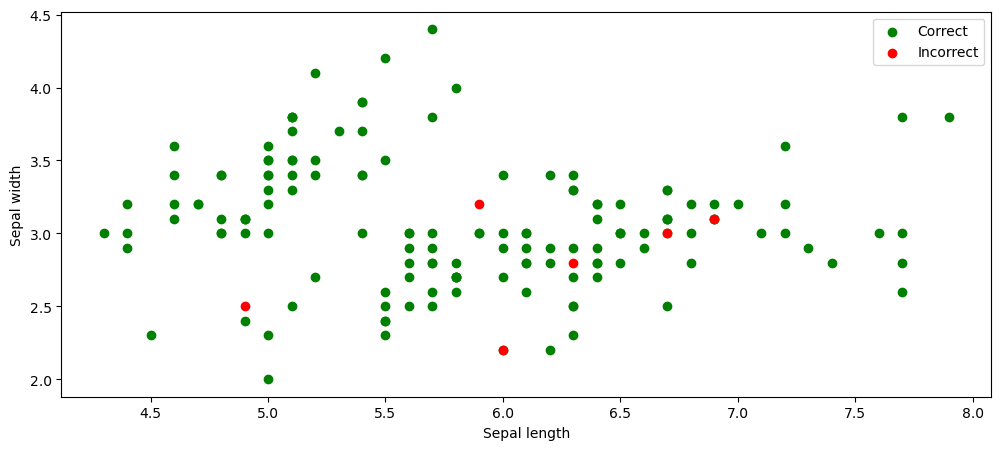

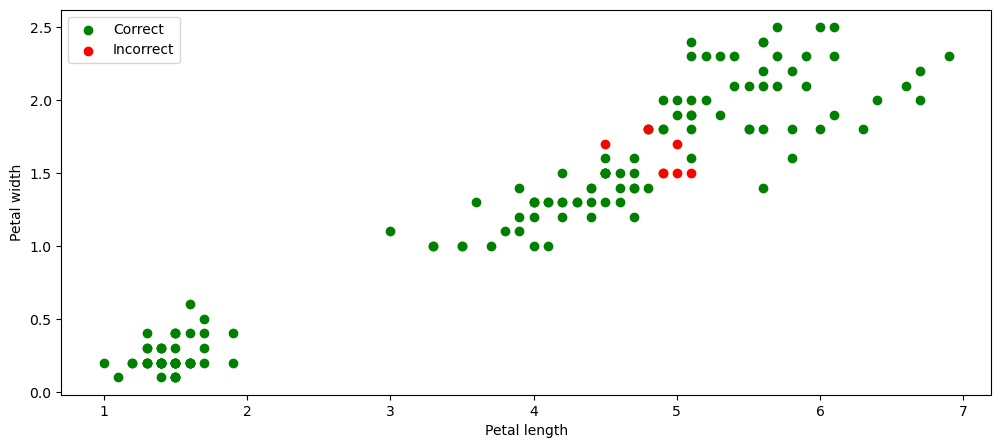

In [653]:
from matplotlib import pyplot as plt

# Get the guessed labels for the iris dataset and plot the results
iris_guessed_labels = classify_flowers(iris_features, iris_prior, means, stds)
correct = iris_labels == iris_guessed_labels

plt.figure(figsize=(12, 5))
# Plot the correct guesses
plt.scatter(iris_features[correct]['sepal_length'], iris_features[correct]['sepal_width'], color='green', label='Correct')
# Plot the incorrect guesses
plt.scatter(iris_features[~correct]['sepal_length'], iris_features[~correct]['sepal_width'], color='red', label='Incorrect')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
# Plot the correct guesses
plt.scatter(iris_features[correct]['petal_length'], iris_features[correct]['petal_width'], color='green', label='Correct')
# Plot the incorrect guesses
plt.scatter(iris_features[~correct]['petal_length'], iris_features[~correct]['petal_width'], color='red', label='Incorrect')
plt.xlabel('Petal length')
plt.ylabel('Petal width')
plt.legend()
plt.show()

We observed that the average 10-fold cross validation accuracy is around 0.94-0.96 depending on the run as the data is shuffled differently each time. F1 score seems to be around 0.93-0.95. 

These both indicate that our classifier performs really well, meaning that it makes the correct predictions. From the high F1 score it is evident that our classifier is correctly identifying positive instances while minimizing false positives and false negatives.